Import modules


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

Load data from .mat file

In [2]:
data_path = 'data/tpu_aerodynamic_database.mat'
mat_data = loadmat(data_path)

Extract relevant fields

In [3]:
roof_pitch = mat_data['Roof_pitch'].flatten()
roof_type = mat_data['Roof_type'].flatten()
sample_frequency = mat_data['Sample_frequency'].flatten()
building_depth = mat_data['Building_depth'].flatten()
building_breadth = mat_data['Building_breadth'].flatten()
building_height = mat_data['Building_height'].flatten()
wind_direction_angle = mat_data['Wind_direction_angle'].flatten()
wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']

mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)

Create feature matrix and target

In [4]:
num_samples = mean_pressure_coefficients.shape[0]
features = pd.DataFrame({
    "Roof_pitch": np.tile(roof_pitch, num_samples // len(roof_pitch)),
    "Roof_type": np.tile(roof_type, num_samples // len(roof_type)),
    "Sample_frequency": np.tile(sample_frequency, num_samples // len(sample_frequency)),
    "Building_depth": np.tile(building_depth, num_samples // len(building_depth)),
    "Building_breadth": np.tile(building_breadth, num_samples // len(building_breadth)),
    "Building_height": np.tile(building_height, num_samples // len(building_height)),
    "Wind_direction_angle": np.tile(wind_direction_angle, num_samples // len(wind_direction_angle)),
})
features["Mean_pressure_coefficient"] = mean_pressure_coefficients

In [5]:
# One-hot encode Roof_type
features = pd.get_dummies(features, columns=["Roof_type"], drop_first=True)

In [6]:
# Split data into train and test sets
X = features.drop(columns=["Mean_pressure_coefficient"])
y = features["Mean_pressure_coefficient"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             max_depth=3,
                             learning_rate=0.1,
                             random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [10]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

In [11]:
print(f"XGBoost - MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, MAPE: {mape_xgb:.2f}%")

XGBoost - MSE: 0.0164, MAE: 0.0972, MAPE: 52.01%


In [12]:
# --- Physics-Informed Machine Learning (PIML) with PyTorch ---
class PressureDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = PressureDataset(X_train_scaled, y_train.values)
test_dataset = PressureDataset(X_test_scaled, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [13]:
model = RegressionModel(input_size=X_train_scaled.shape[1])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 0.0186
Epoch [2/50], Loss: 0.0179
Epoch [3/50], Loss: 0.0179
Epoch [4/50], Loss: 0.0178
Epoch [5/50], Loss: 0.0179
Epoch [6/50], Loss: 0.0178
Epoch [7/50], Loss: 0.0178
Epoch [8/50], Loss: 0.0179
Epoch [9/50], Loss: 0.0178
Epoch [10/50], Loss: 0.0178
Epoch [11/50], Loss: 0.0178
Epoch [12/50], Loss: 0.0178
Epoch [13/50], Loss: 0.0178
Epoch [14/50], Loss: 0.0178
Epoch [15/50], Loss: 0.0178
Epoch [16/50], Loss: 0.0178
Epoch [17/50], Loss: 0.0178
Epoch [18/50], Loss: 0.0178
Epoch [19/50], Loss: 0.0178
Epoch [20/50], Loss: 0.0178
Epoch [21/50], Loss: 0.0178
Epoch [22/50], Loss: 0.0178
Epoch [23/50], Loss: 0.0178
Epoch [24/50], Loss: 0.0178
Epoch [25/50], Loss: 0.0178
Epoch [26/50], Loss: 0.0178
Epoch [27/50], Loss: 0.0177
Epoch [28/50], Loss: 0.0177
Epoch [29/50], Loss: 0.0178
Epoch [30/50], Loss: 0.0177
Epoch [31/50], Loss: 0.0178
Epoch [32/50], Loss: 0.0178
Epoch [33/50], Loss: 0.0178
Epoch [34/50], Loss: 0.0178
Epoch [35/50], Loss: 0.0178
Epoch [36/50], Loss: 0.0178
E

In [14]:
# Evaluate PIML model
model.eval()
y_pred_p = []
y_true_p = []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        y_pred_p.append(outputs.squeeze().numpy())
        y_true_p.append(targets.numpy())

y_pred_p = np.concatenate(y_pred_p)
y_true_p = np.concatenate(y_true_p)

mse_p = mean_squared_error(y_true_p, y_pred_p)
mae_p = mean_absolute_error(y_true_p, y_pred_p)
mape_p = np.mean(np.abs((y_true_p - y_pred_p) / y_true_p)) * 100

print(f"PIML - MSE: {mse_p:.4f}, MAE: {mae_p:.4f}, MAPE: {mape_p:.2f}%")

PIML - MSE: 0.0164, MAE: 0.0971, MAPE: 51.94%


In [15]:
print("True values range:", y_test.min(), y_test.max())
print("XGBoost predictions range:", y_pred_xgb.min(), y_pred_xgb.max())
print("PIML predictions range:", y_pred_p.min(), y_pred_p.max())


True values range: -0.80281407 0.1907532
XGBoost predictions range: -0.33356357 -0.33356357
PIML predictions range: -0.33313918 -0.33313918


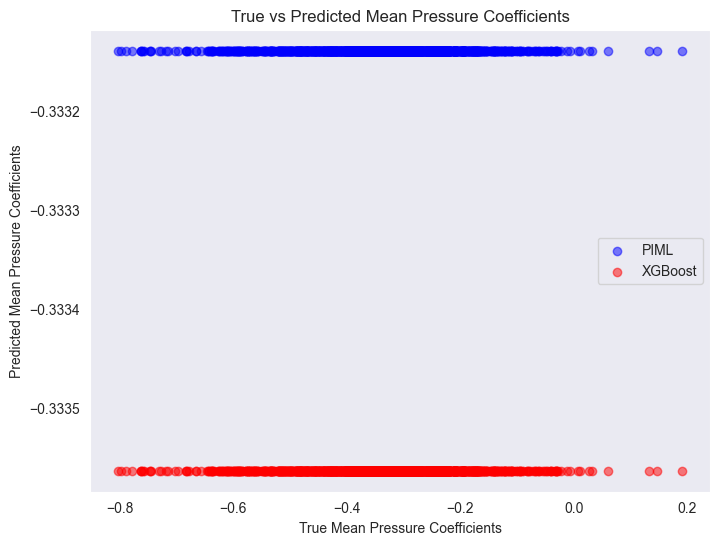

In [16]:
# Visualizations
plt.figure(figsize=(8, 6))
plt.scatter(y_true_p, y_pred_p, alpha=0.5, color='blue', label='PIML')
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='red', label='XGBoost')
plt.xlabel("True Mean Pressure Coefficients")
plt.ylabel("Predicted Mean Pressure Coefficients")
plt.title("True vs Predicted Mean Pressure Coefficients")
plt.legend()
plt.grid()
plt.show()

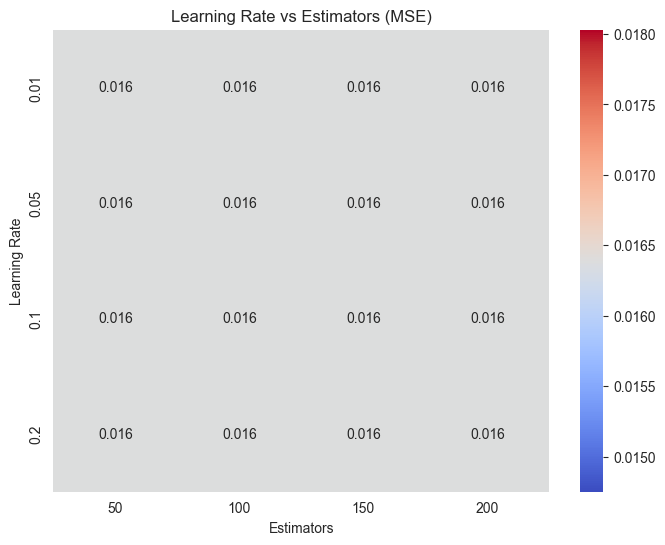

In [17]:
# Learning rate vs estimators for XGBoost
learning_rates = [0.01, 0.05, 0.1, 0.2]
estimators = [50, 100, 150, 200]
results = []

for lr in learning_rates:
    for est in estimators:
        model = xgb.XGBRegressor(learning_rate=lr, n_estimators=est, max_depth=3, random_state=42)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        results.append((lr, est, mse))

results_df = pd.DataFrame(results, columns=["Learning Rate", "Estimators", "MSE"])

# Create pivot table for heatmap
pivot = results_df.pivot(index="Learning Rate", columns="Estimators", values="MSE")

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.title("Learning Rate vs Estimators (MSE)")
plt.xlabel("Estimators")
plt.ylabel("Learning Rate")
plt.show()

In [19]:
correlation_matrix = features["Mean_pressure_coefficient"].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


IndexError: too many indices for tensor of dimension 2